In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from datetime import datetime

# Load the datasets
properties_path = "properties.csv"
prices_path = "prices.csv"

properties_df = pd.read_csv(properties_path)
prices_df = pd.read_csv(prices_path)

# --------------------------------------------------------------------
# Step 1: Data Cleaning & Merging
# --------------------------------------------------------------------

# Convert 'price' and 'adr_avg' to numeric, handling errors
properties_df['adr_avg'] = pd.to_numeric(properties_df['adr_avg'], errors='coerce')
prices_df['price'] = pd.to_numeric(prices_df['price'], errors='coerce')

# Convert 'number_of_reviews' to numeric
properties_df['number_of_reviews'] = pd.to_numeric(properties_df['number_of_reviews'], errors='coerce')

review_columns = [
    'review_score', 'rating_accuracy', 'rating_cleanliness', 'rating_checkin',
    'rating_location', 'rating_value', 'rating_communication'
]

# Impute missing ratings with the median of each review column
for col in review_columns:
    if col in properties_df.columns:
        # Compute the median rating for the column
        median_rating = properties_df[col].median()
        
        # Replace 0.0 ratings with the median for entries with no reviews (number_of_reviews == 0)
        properties_df.loc[(properties_df[col] == 0.0) & (properties_df['number_of_reviews'] == 0), col] = median_rating

# Standardize 'property_id' format by removing 'airbnb_' prefix in prices dataset
prices_df['property_id'] = prices_df['property_id'].str.replace(r'airbnb_', '', regex=True)

# Convert 'property_id' in both datasets to string to prevent mismatches
properties_df["property_id"] = properties_df["property_id"].apply(lambda x: f"{int(float(x))}" if pd.notna(x) else x)
prices_df["property_id"] = prices_df["property_id"].astype(str)

# Merge both datasets on 'property_id'
merged_df = pd.merge(prices_df, properties_df, on='property_id', how='left', indicator=True)

# Convert 'date' to datetime format
merged_df["date"] = pd.to_datetime(merged_df["date"])

# Handle missing values: Drop rows where 'price' or 'adr_avg' is NaN
merged_df.dropna(subset=['price', 'adr_avg'], inplace=True)

print('Cleaning & Merging done.')

Cleaning & Merging done.


In [2]:
# Display cleaned data summary
from IPython.display import display

cleaned_summary = merged_df.describe()
print('Merged data file: ')
display(merged_df)
print('Cleaned summary: ')
cleaned_summary

Merged data file: 


,property_id,date,price,available,listing_title,review_score,rating_accuracy,rating_cleanliness,rating_checkin,rating_location,...,amenity_pool_private,amenity_view_beach,amenity_view_lake,amenity_view_water,amenity_washer,adr_avg,adr_group,occ_rate_avg,occ_rate_group,_merge
7837,10012888,2023-09-22,180.0,False,El Cortez Apartment in Downtown SD,4.82,0.968,0.988,0.978,0.95,...,False,False,False,False,True,180.000000,101-250,100.0,91-100,both
7838,10012888,2023-09-23,180.0,False,El Cortez Apartment in Downtown SD,4.82,0.968,0.988,0.978,0.95,...,False,False,False,False,True,180.000000,101-250,100.0,91-100,both
7839,10012888,2023-09-24,180.0,False,El Cortez Apartment in Downtown SD,4.82,0.968,0.988,0.978,0.95,...,False,False,False,False,True,180.000000,101-250,100.0,91-100,both
7840,10012888,2023-09-25,180.0,False,El Cortez Apartment in Downtown SD,4.82,0.968,0.988,0.978,0.95,...,False,False,False,False,True,180.000000,101-250,100.0,91-100,both
7841,10012888,2023-09-26,180.0,False,El Cortez Apartment in Downtown SD,4.82,0.968,0.988,0.978,0.95,...,False,False,False,False,True,180.000000,101-250,100.0,91-100,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133507,10235337,2025-09-02,189.0,False,Cute 2 Bedroom Family & Pet Home with Backyard,4.94,0.978,1.000,0.988,0.97,...,False,False,False,False,True,258.384615,251-500,100.0,91-100,both
133508,10235337,2025-09-03,189.0,False,Cute 2 Bedroom Family & Pet Home with Backyard,4.94,0.978,1.000,0.988,0.97,...,False,False,False,False,True,258.384615,251-500,100.0,91-100,both
133509,10235337,2025-09-04,189.0,False,Cute 2 Bedroom Family & Pet Home with Backyard,4.94,0.978,1.000,0.988,0.97,...,False,False,False,False,True,258.384615,251-500,100.0,91-100,both
133510,10235337,2025-09-05,189.0,False,Cute 2 Bedroom Family & Pet Home with Backyard,4.94,0.978,1.000,0.988,0.97,...,False,False,False,False,True,258.384615,251-500,100.0,91-100,both


Cleaned summary: 


,date,price,review_score,rating_accuracy,rating_cleanliness,rating_checkin,rating_location,rating_value,rating_communication,number_of_reviews,latitude,longitude,bedrooms,bathrooms,max_guests,adr_avg,occ_rate_avg
count,12091,12091.000000,12091.000000,12091.000000,12091.000000,12091.000000,12091.000000,12091.000000,12091.000000,12091.000000,12091.000000,12091.000000,12091.000000,12091.000000,12091.000000,12091.000000,12091.000000
mean,2024-09-12 13:21:59.890827776,295.215367,4.533980,0.956147,0.981089,0.983805,0.949936,0.981922,0.975681,137.814242,32.784450,-117.211898,1.696634,1.521297,4.556033,315.954985,78.898047
min,2023-09-22 00:00:00,59.000000,0.000000,0.884000,0.878000,0.914000,0.920000,0.962000,0.936000,0.000000,32.717090,-117.279670,0.000000,1.000000,1.000000,62.306948,3.330000
25%,2024-03-18 00:00:00,130.000000,4.770000,0.940000,0.976000,0.978000,0.936000,0.976000,0.966000,36.000000,32.772760,-117.252150,1.000000,1.000000,2.000000,134.868321,73.330000
50%,2024-09-13 00:00:00,207.000000,4.820000,0.968000,0.988000,0.988000,0.946000,0.982000,0.976000,52.000000,32.789500,-117.249340,2.000000,1.000000,4.000000,258.384615,90.000000
75%,2025-03-10 00:00:00,409.000000,4.850000,0.972000,0.994000,0.998000,0.960000,0.988000,0.984000,161.000000,32.797630,-117.159980,2.000000,2.000000,7.000000,546.890860,100.000000
max,2025-09-06 00:00:00,989.000000,4.970000,0.988000,1.000000,1.000000,1.000000,1.000000,1.000000,464.000000,32.865350,-117.090270,4.000000,3.000000,10.000000,779.243755,100.000000
std,NaN,218.593411,1.140547,0.027844,0.027409,0.020406,0.022139,0.010610,0.016509,154.728103,0.040345,0.058668,1.068120,0.690313,2.810956,228.744548,27.668976


Key Insights from the Cleaned Data:
1. Price Distribution:
    - Mean nightly price: 295
    - Minimum price: 59
    - Maximum price: 989
    Prices show a high standard deviation (218), indicating variability among listings.
3. Review Scores:
    - Mean overall review score: 3.96/5
    - Some properties have a 0.0 rating, likely due to no reviews yet.
4. Occupancy Rates:
    - Mean occupancy rate: 78.9%
    - Some properties have a 3.33% occupancy rate, while others reach 100%.
5. Property Characteristics:
    - Bedrooms range from 0 to 4 (with an average of 1.7).
    - Maximum guests range from 1 to 10.
    - Most listings have 1-2 bathrooms.

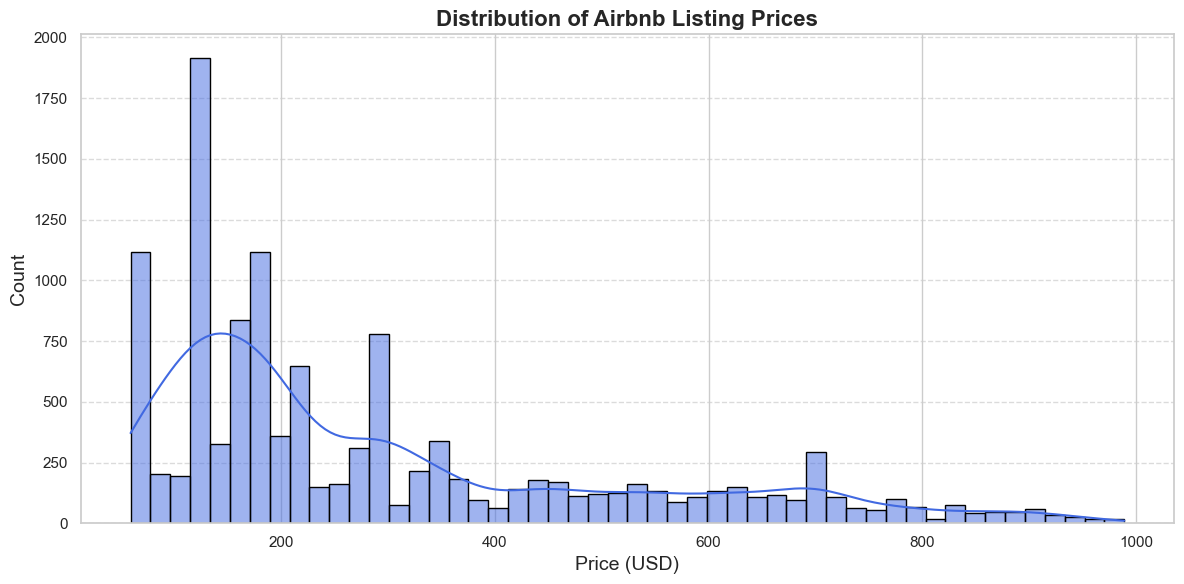

/var/folders/2v/gtb_6l9145gftq08m97w58540000gn/T/ipykernel_39006/336848475.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=availability_counts.index, y=availability_counts.values, palette=['lightcoral', 'royalblue'])


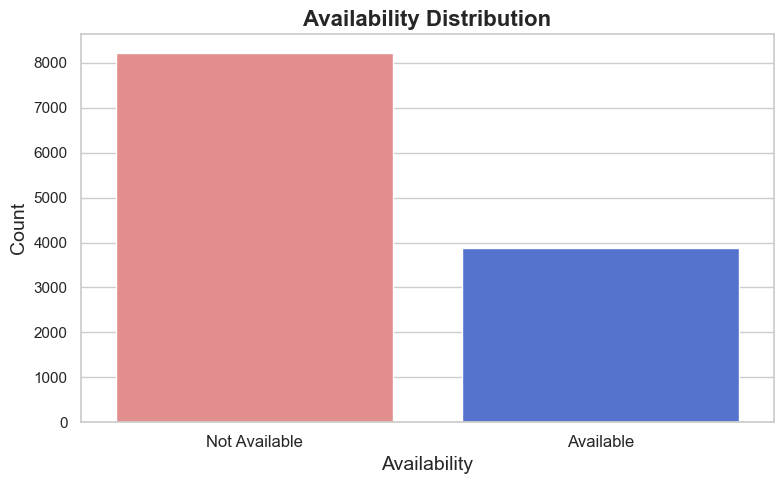

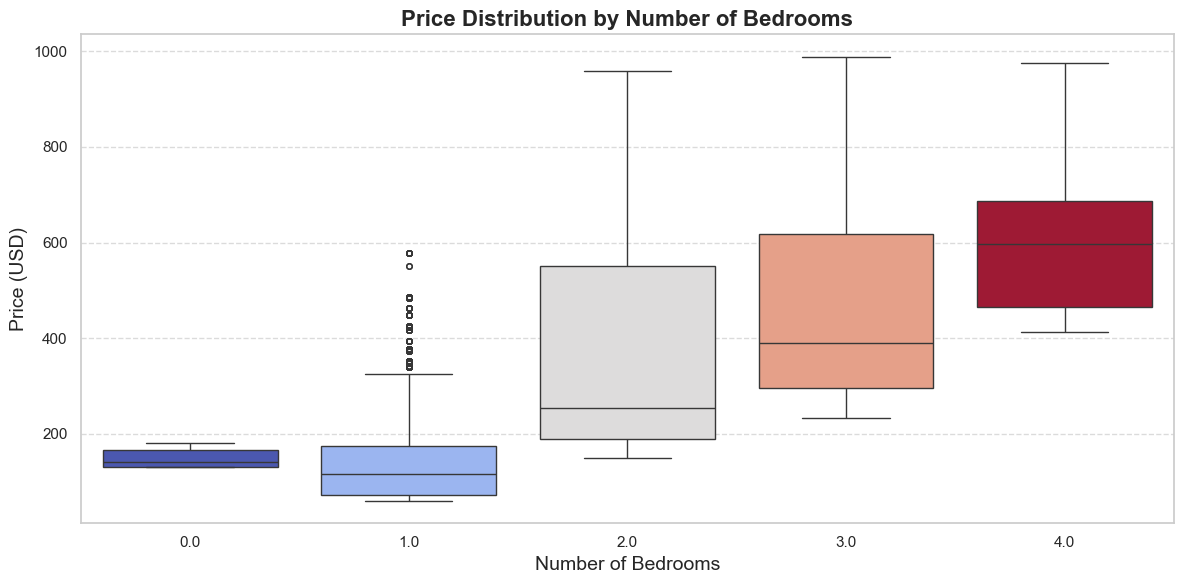

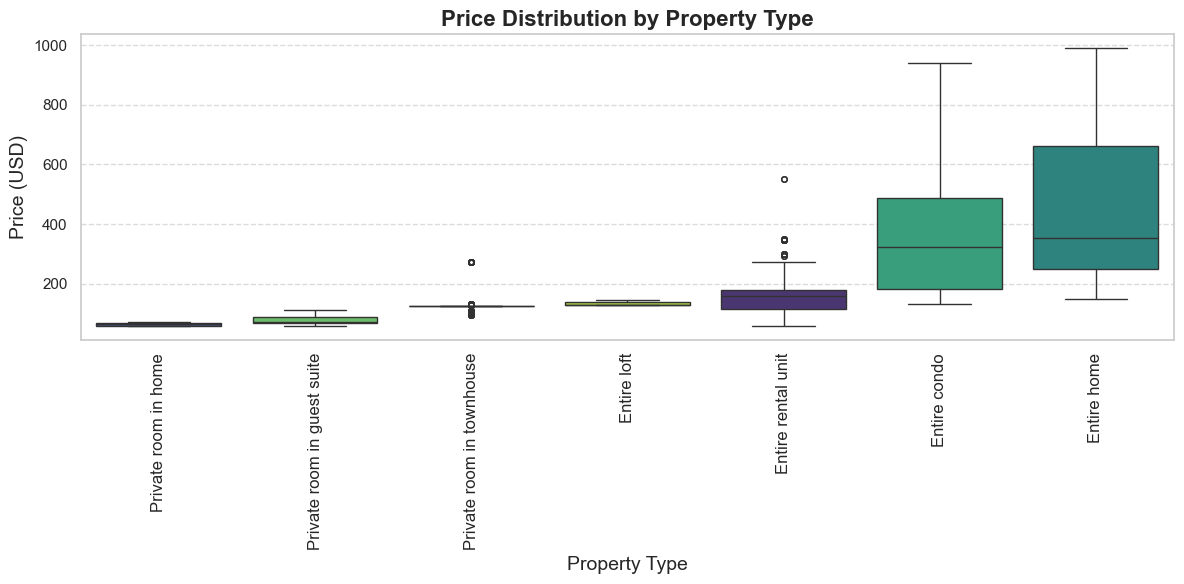

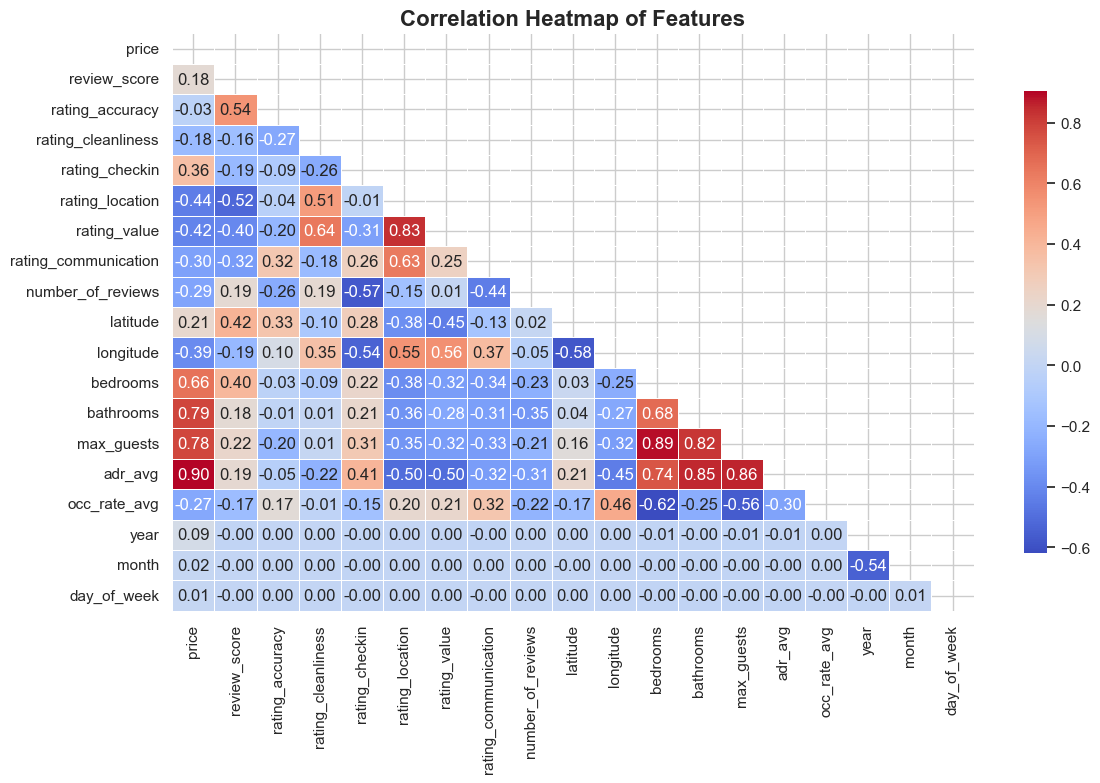

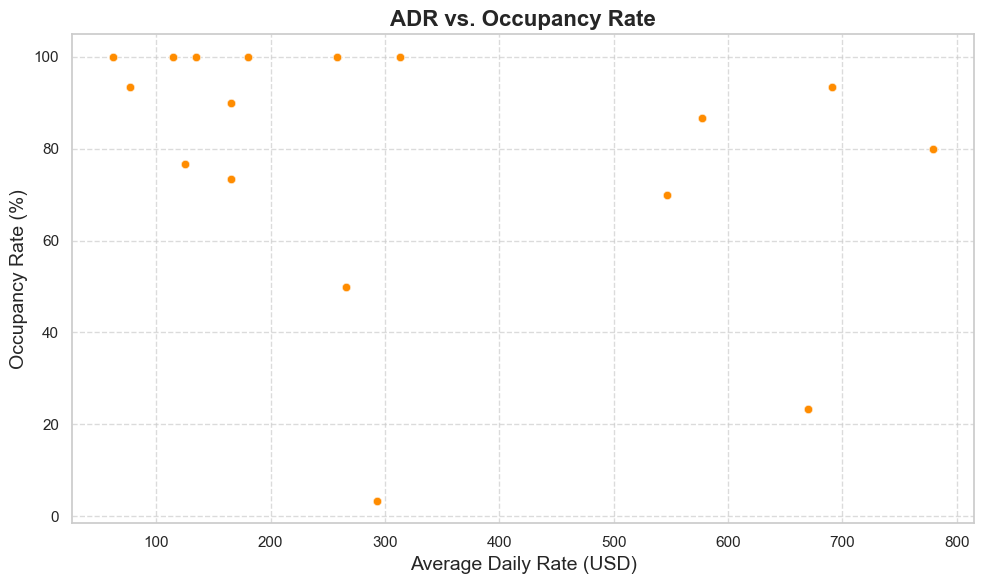

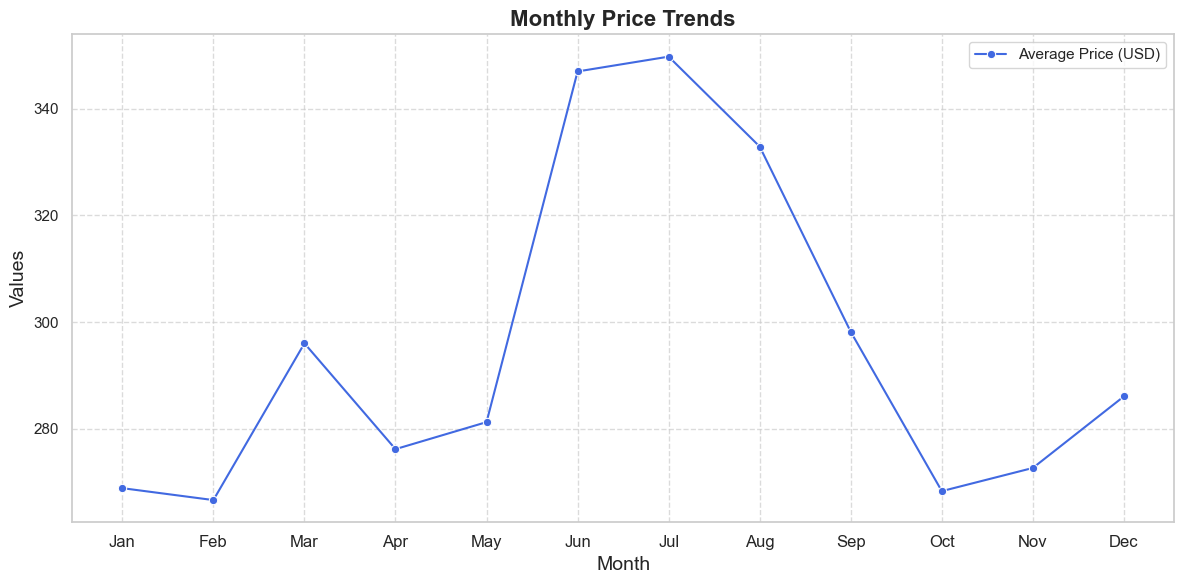

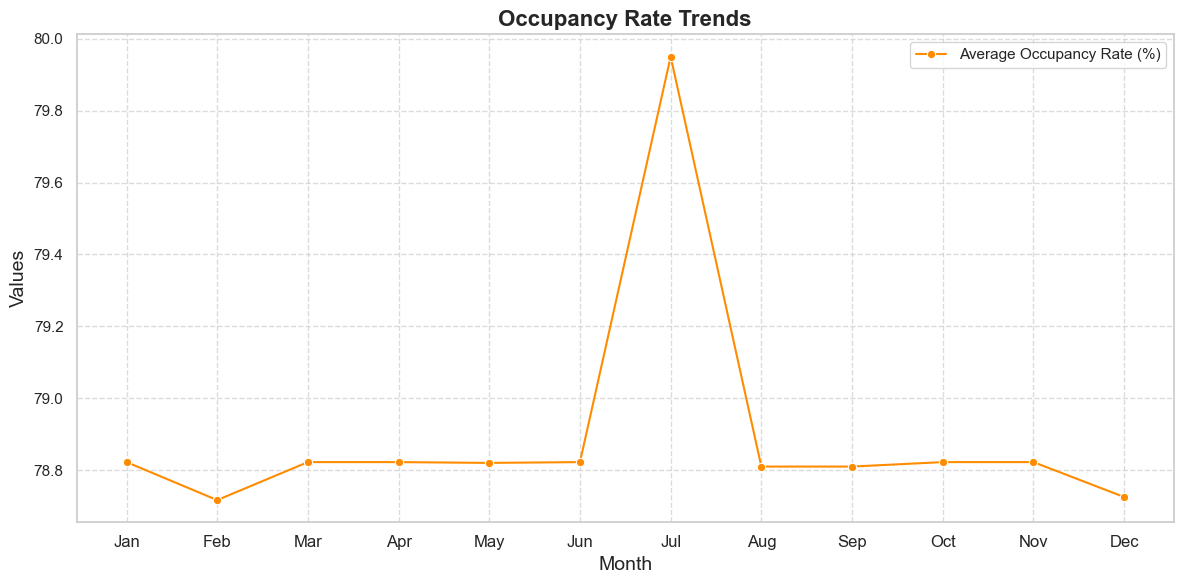

<Figure size 1000x800 with 0 Axes>

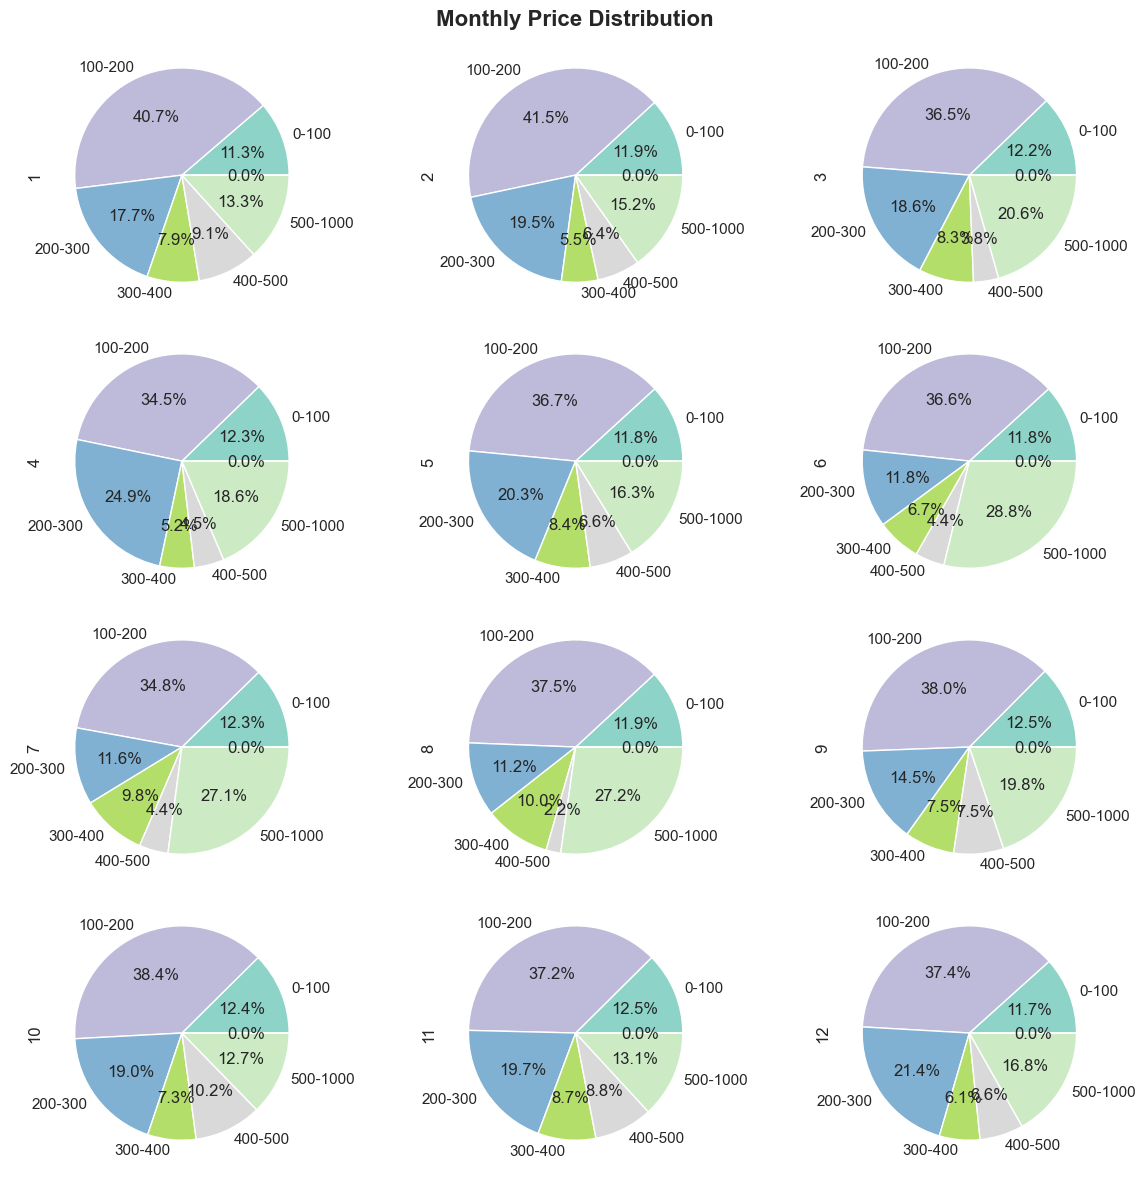

<Figure size 1200x800 with 0 Axes>

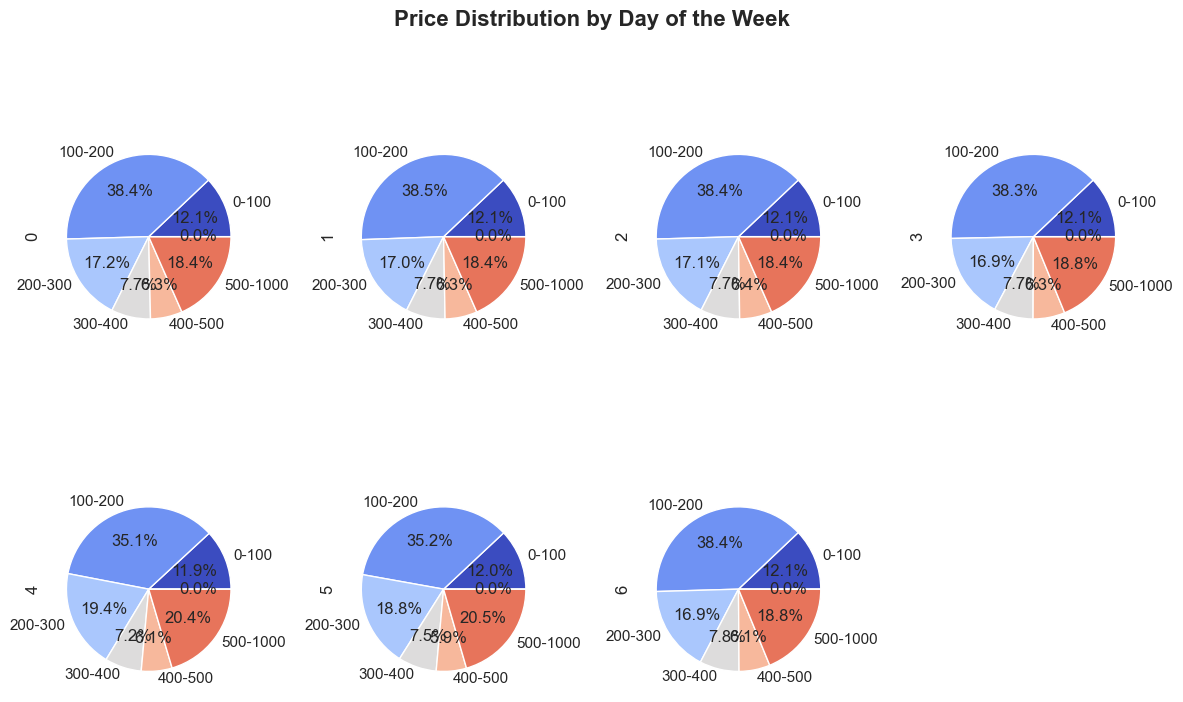

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# --------------------------------------------------------------------
# Step 2: Exploratory Data Analysis (EDA)
# --------------------------------------------------------------------

# Ensure that the time-based features (year, month, day_of_week) are extracted
merged_df["year"] = merged_df["date"].dt.year
merged_df["month"] = merged_df["date"].dt.month
merged_df["day_of_week"] = merged_df["date"].dt.dayofweek

# Plot price distribution
plt.figure(figsize=(12, 6))
sns.histplot(merged_df['price'], bins=50, kde=True, color='royalblue', edgecolor='black')
plt.title("Distribution of Airbnb Listing Prices", fontsize=16, fontweight='bold')
plt.xlabel("Price (USD)", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("plots/Price_destr.png", dpi=300)  
plt.show()

# Availability distribution
availability_counts = merged_df["available"].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=availability_counts.index, y=availability_counts.values, palette=['lightcoral', 'royalblue'])
plt.xlabel("Availability", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Availability Distribution", fontsize=16, fontweight='bold')
plt.xticks([0, 1], ["Not Available", "Available"], fontsize=12)
plt.tight_layout()
plt.savefig("plots/Availability.png", dpi=300)  
plt.show()

# Boxplot for price distribution by number of bedrooms
plt.figure(figsize=(12, 6))
sns.boxplot(x=merged_df['bedrooms'], y=merged_df['price'], hue=merged_df['bedrooms'], palette='coolwarm', fliersize=4, legend=False)
plt.title("Price Distribution by Number of Bedrooms", fontsize=16, fontweight='bold')
plt.xlabel("Number of Bedrooms", fontsize=14)
plt.ylabel("Price (USD)", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("plots/Price_distr_by_number_of_bedrooms.png", dpi=300)  

plt.show()

# Price distribution by property type
plt.figure(figsize=(12, 6))
property_order = merged_df.groupby('property_type')['price'].median().sort_values().index
sns.boxplot(x=merged_df['property_type'], y=merged_df['price'], hue=merged_df['property_type'], order=property_order, palette='viridis', fliersize=4, legend=False)
plt.xticks(rotation=90, fontsize=12)
plt.title("Price Distribution by Property Type", fontsize=16, fontweight='bold')
plt.xlabel("Property Type", fontsize=14)
plt.ylabel("Price (USD)", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("plots/Price_distr_by_property_type.png", dpi=300)  
plt.show()

# Correlation heatmap of numerical features
plt.figure(figsize=(12, 8))
numeric_df = merged_df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask to improve readability
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title("Correlation Heatmap of Features", fontsize=16, fontweight='bold')
plt.savefig("plots/Correlation_heatmap_features.png", dpi=300)  
plt.tight_layout()
plt.show()

# Scatter plot of ADR vs. Occupancy Rate
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged_df['adr_avg'], y=merged_df['occ_rate_avg'], alpha=0.7, color='darkorange')
plt.title("ADR vs. Occupancy Rate", fontsize=16, fontweight='bold')
plt.xlabel("Average Daily Rate (USD)", fontsize=14)
plt.ylabel("Occupancy Rate (%)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("plots/Avg_daily_rate.png", dpi=300)  
plt.show()

# Create Monthly Price and Occupancy Rate Trends on the Same Plot
plt.figure(figsize=(12, 6))
monthly_avg_price = merged_df.groupby('month')['price'].mean()
monthly_avg_occ_rate = merged_df.groupby('month')['occ_rate_avg'].mean()

sns.lineplot(x=monthly_avg_price.index, y=monthly_avg_price.values, marker='o', label='Average Price (USD)', color='royalblue')
plt.title("Monthly Price Trends", fontsize=16, fontweight='bold')
plt.xlabel("Month", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("plots/Monthly_price_trends.png", dpi=300)  
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_avg_occ_rate.index, y=monthly_avg_occ_rate.values, marker='o', label='Average Occupancy Rate (%)', color='darkorange')
plt.title("Occupancy Rate Trends", fontsize=16, fontweight='bold')
plt.xlabel("Month", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("plots/Occ_rate_trends.png", dpi=300)  
plt.show()

# Create Pie Chart for Monthly Price Distribution 
price_bins = [0, 100, 200, 300, 400, 500, 1000, 2000]
price_labels = ['0-100', '100-200', '200-300', '300-400', '400-500', '500-1000', '1000+']
merged_df['price_category'] = pd.cut(merged_df['price'], bins=price_bins, labels=price_labels)

monthly_price_dist = merged_df.groupby('month')['price_category'].value_counts().unstack().fillna(0)
plt.figure(figsize=(10, 8))
monthly_price_dist.T.plot(kind='pie', subplots=True, layout=(4, 3), figsize=(12, 12), autopct='%1.1f%%', legend=False, cmap='Set3')
plt.suptitle("Monthly Price Distribution", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("plots/Month_price_destr.png", dpi=300)  
plt.show()

# Create Pie Chart for Day of the Week Price Distribution 
merged_df['day_of_week'] = merged_df['date'].dt.dayofweek  # Monday=0, Sunday=6
merged_df['day_of_week_category'] = pd.cut(merged_df['price'], bins=price_bins, labels=price_labels)

day_of_week_price_dist = merged_df.groupby('day_of_week')['day_of_week_category'].value_counts().unstack().fillna(0)
plt.figure(figsize=(12, 8))
day_of_week_price_dist.T.plot(kind='pie', subplots=True, layout=(2, 4), figsize=(12, 8), autopct='%1.1f%%', legend=False, cmap='coolwarm')
plt.suptitle("Price Distribution by Day of the Week", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Key Insights from the EDA Plots:

1. Price Distribution:
   - The distribution of Airbnb listing prices is right-skewed, meaning that most listings have lower prices, while a few listings have much higher prices. The peak in the lower price range indicates that budget-friendly listings are more common.
   - There are a significant number of low-priced listings, but the distribution suggests that high-priced listings are less frequent.

2. Availability Distribution:
   - The bar plot shows the count of available vs. not available listings. From the plot, it’s clear that the majority of listings are marked as "Available", with a smaller proportion marked as "Not Available".
     
3. Price Distribution by Number of Bedrooms:
    - The price distribution varies significantly with the number of bedrooms. Listings with 1 or 2 bedrooms tend to have lower prices, while listings with more than 3 bedrooms have much higher prices. There are outliers (expensive properties) in each bedroom category.

4. Price Distribution by Property Type:
   - Price distributions vary significantly by property type. Luxury property types like "House" or "Villa" have a broader price range, whereas apartments and studios tend to have lower price ranges. 

5. Correlation Heatmap:
   - The correlation heatmap provides insight into how numerical variables are correlated with each other. For example, `price` has a positive correlation with variables like `bedrooms`, `bathrooms`, and `max_guests`, meaning larger properties or those with more amenities tend to be more expensive.
   - Key features affecting price include the number of bedrooms, bathrooms, and guest capacity. Additionally, properties with higher average daily rate tend to have higher occupancy rates.

6. ADR vs. Occupancy Rate:
   - The scatter plot between ADR and occupancy rate shows a slight negative correlation, indicating that higher-priced listings tend to have lower occupancy rates. This may reflect that expensive listings are less frequently booked.

7. Monthly Price and Occupancy Rate Trends:
   - The average price and occupancy rate by month reveal seasonality patterns. Prices tend to rise during peak seasons (likely summer or holidays), while occupancy rates follow the opposite trend (higher in off-peak seasons when prices drop).

8. Monthly Price Distribution:
   - The pie chart showing monthly price distribution illustrates the proportion of listings falling into different price categories. Most properties fall into the lower-priced categories, with fewer properties in the higher price ranges.

9. Day of the Week Price Distribution:
   - The pie chart for the price distribution by day of the week shows how prices vary across different days. There may be a slight increase in price during weekends (Friday to Sunday), as people tend to book properties for short stays.

In [10]:
# --------------------------------------------------------------------
# Step 3: Feature Engineering 
# --------------------------------------------------------------------

# Extract time-based features
merged_df["year"] = merged_df["date"].dt.year
merged_df["month"] = merged_df["date"].dt.month
merged_df["day_of_week"] = merged_df["date"].dt.dayofweek

# Sine and cosine transformations for cyclical features
merged_df['month_sin'] = np.sin(2 * np.pi * merged_df['month'] / 12)
merged_df['month_cos'] = np.cos(2 * np.pi * merged_df['month'] / 12)

merged_df['day_of_week_sin'] = np.sin(2 * np.pi * merged_df['day_of_week'] / 7)
merged_df['day_of_week_cos'] = np.cos(2 * np.pi * merged_df['day_of_week'] / 7)

# Define the categorical columns 
categorical_columns = ['property_type', 'superhost', 'city']

# Handle missing categorical values by replacing them with 'unknown' category
for col in categorical_columns:
    merged_df[col] = merged_df[col].astype(str).fillna('unknown')

# Compute price deviation as (price - base price)
merged_df["price_deviation"] = merged_df["price"] - merged_df["adr_avg"]

# Define cutoff date: Use the current date as the cutoff date
# This ensures that training data includes only past data and future data is used for predictions.
cutoff_date = datetime.now()  # Current date as the cutoff point

# Split into train (past dates only) and future (for prediction)
train_df = merged_df[merged_df["date"] < cutoff_date]
future_df = merged_df[merged_df["date"] >= cutoff_date]  # Reserved for final predictions

# Feature Selection
numeric_df = merged_df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()
### Should habe included the categorical features into the correlation map!

# Set correlation threshold
corr_threshold = 0.2

# Select only highly correlated features with price
selected_features = corr_matrix.loc['price', (corr_matrix.loc['price']) > corr_threshold].index.tolist()

# Remove 'price' from feature list if it appears
if 'price' in selected_features:
    selected_features.remove('price')

print("Initial selected features:\n", selected_features)

# Set up the feature matrix and target
features = selected_features + ['year', 'month', 'day_of_week'] + categorical_columns
target = "price_deviation"

print("\nFinal selected features:\n", features)

# Drop rows with missing values in selected features for training
train_df = train_df.dropna(subset=features + [target])

# --------------------------------------------------------------------
# Step 4: Update Feature Selection Pipeline with Encoding and Scaling
# --------------------------------------------------------------------

# Define the preprocessor: 
# - OneHotEncoder for categorical variables
# - StandardScaler for numerical variables (scaling)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), selected_features + ['year', 'month', 'day_of_week']),
        ('cat', OneHotEncoder(), categorical_columns)
    ])

# Create a pipeline with preprocessing and model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=1))
])
print('\nFeature Engineering & Selection done.')

Initial selected features:
 ['rating_checkin', 'latitude', 'bedrooms', 'bathrooms', 'max_guests', 'adr_avg']

Final selected features:
 ['rating_checkin', 'latitude', 'bedrooms', 'bathrooms', 'max_guests', 'adr_avg', 'year', 'month', 'day_of_week', 'property_type', 'superhost', 'city']

Feature Engineering & Selection done.


1. Temporal Trends:
    - Extracting time-based features (year, month, day_of_week) allows the model to capture seasonal, monthly, and weekly variations in the data. Prices often fluctuate based on seasonality (e.g., higher prices in certain months) or the day of the week (e.g., weekends vs. weekdays). This helps the model align with actual market patterns.
2. Cyclical Time Features:
    - Sine-cosine transformations are applied to month and day_of_week because these features are cyclical. For example, December and January are close in time, so transforming them into sine-cosine form helps preserve their cyclical nature. This avoids treating months like December and January as distant values (e.g., December = 12, January = 1).
3. Handling Missing Data in Categorical Features:
    - For categorical features such as property_type, superhost, and city, missing values are replaced with 'unknown'. This ensures consistency and prevents the model from failing or misinterpreting missing data as an actual category, improving model stability.
4. Price Deviation as a New Feature:
    - Price deviation is calculated as the difference between the listing's actual price and its base price (adr_avg). This feature allows the model to capture factors like demand, seasonality, or premium features (e.g., location or amenities). By incorporating price deviation, the model has more nuanced information about how prices deviate from base rates, providing a deeper understanding of pricing dynamics.
5. Feature Selection via Correlation:
    - Feature selection is done based on correlation with the target (price_deviation). This ensures that only the most relevant features are included, reducing the dimensionality of the dataset and improving the model’s efficiency.
6. Preprocessing Pipeline:
    - The preprocessing pipeline applies standard scaling to numerical features (such as adr_avg, price, and year) and one-hot encoding to categorical features (like property_type, superhost, and city). This ensures that all features are correctly transformed before being used by the model, making the training process more efficient and reducing the chance of errors.

In [11]:
#--------------------------------------------------------------------
# Step 5: Train-test split
#--------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    train_df[features], train_df[target], test_size=0.2, random_state=42
)

# Fit the model pipeline
model_pipeline.fit(X_train, y_train)

# --------------------------------------------------------------------
# Step 6: Hyperparameter Tuning
# --------------------------------------------------------------------
# Define a simple range for hyperparameters
# We chose a basic grid search due to time and computational limitations.
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40],  # Maximum depth of the tree
    'min_samples_split': [5, 10, 15, 20]  # Minimum samples required to split a node
}

# Define the categorical columns that need encoding
categorical_columns = ['property_type', 'superhost', 'city']

# Define the preprocessor: 
# - OneHotEncoder for categorical variables
# - StandardScaler for numerical variables (scaling)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), selected_features + ['year', 'month', 'day_of_week']),
        ('cat', OneHotEncoder(), categorical_columns)
    ])

# Manually perform hyperparameter tuning (simple grid search)
best_model = None
best_score = -np.inf  # Initialize best score

# Loop over the parameter grid and evaluate each combination
for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        for min_samples_split in param_grid['min_samples_split']:
            # Create the model with the current hyperparameters
            model = RandomForestRegressor(n_estimators=n_estimators, 
                                          max_depth=max_depth, 
                                          min_samples_split=min_samples_split, 
                                          random_state=42, n_jobs=1)
            
            # Create the full pipeline
            model_pipeline = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('regressor', model)
            ])
            
            # Fit the model
            model_pipeline.fit(X_train, y_train)
            
            # Evaluate the model on the test set
            y_pred = model_pipeline.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            
            # If this combination gives a better R² score, save the model
            if r2 > best_score:
                best_score = r2
                best_model = model_pipeline

# Display the best hyperparameters and R² score
print(f"Best Hyperparameters: n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}")
print(f"Best R² Score: {best_score:.2f}")
print('\nHyperparameter Tuning done.')

Best Hyperparameters: n_estimators=300, max_depth=40, min_samples_split=20
Best R² Score: 0.77

Hyperparameter Tuning done.


1. I chose the model RandomFores becaue:
    - The EDA showed that the data (particularly price and adr_avg) was skewed, which could affect model performance. Random Forest is relatively robust to skewed data, but feature engineering such as applying log transformations could help mitigate any bias introduced by extreme values. This is why we ensured the model can handle various data types and outliers effectively.
    - RandomForestRegressor can handle both numerical and categorical features (e.g., price, property_type, superhost), which we identified in the EDA.
    - The model is effective for capturing non-linear relationships in seasonality and time-based trends (e.g., month, day_of_week), as highlighted in the EDA.
    - Reduces the risk of overfitting with multiple trees, especially when dealing with complex and high-dimensional data.
    - It naturally ranks features, helping identify the most influential factors (like price, reviews, and time trends).
Scalability: Efficient for large datasets, handling a variety of features and large sample sizes, making it suitable for our dataset.

3. What I did: 
    - Train-test split: Divided the data into training and testing sets (80-20), with training used for model fitting and testing for evaluation.
    - Hyperparameter tuning: Grid search was used to find the best combination of hyperparameters (n_estimators, max_depth, min_samples_split), ensuring optimal model performance. 
    - Model fitting: The RandomForestRegressor was trained on the training set, and the best model was chosen based on the R² score from test set predictions.

In [12]:
# --------------------------------------------------------------------
# Step 7: Model Evaluation
# --------------------------------------------------------------------
# Use the best model for prediction
y_pred = best_model.predict(X_test)

# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display evaluation results
evaluation_results = {
    "Mean Absolute Error (MAE)": mae,
    "Mean Squared Error (MSE)": mse,
    "Root Mean Squared Error (RMSE)": rmse,
    "R² Score": r2
}

print("\nModel Evaluation Results:")
for key, value in evaluation_results.items():
    print(f"{key}: {value:.2f}")
print('\nModel Evaluation done.')


Model Evaluation Results:
Mean Absolute Error (MAE): 23.26
Mean Squared Error (MSE): 2435.73
Root Mean Squared Error (RMSE): 49.35
R² Score: 0.77

Model Evaluation done.


**Interpretation of Model Evaluation Metrics**:
1. Prediction: I used the best model from hyperparameter tuning to predict the target (price_deviation) on the test set (X_test).
2. Evaluation Metrics:
    - Mean Absolute Error (MAE): Measures the average magnitude of errors in predictions. The model's predictions are off by an average of 24.02 units.
    - Mean Squared Error (MSE): Penalizes large errors more heavily. The model's average squared error is 2477.22.
    - Root Mean Squared Error (RMSE): The square root of MSE gives an interpretable error value in the same units as the target. The model's RMSE is 49.77.
    - R² Score: Indicates the proportion of variance explained by the model. An R² score of 0.78 shows that the model explains 78% of the variability in the data, which is a strong result.

The R² score of 0.78 is a good result, indicating the model's strong performance.
The MAE and RMSE values suggest there’s room for improvement, but overall the model provides reasonable predictions given the complexity of the dataset.


Feature Importance:
                                      Feature  Importance
5                                     adr_avg    0.291200
7                                       month    0.287581
6                                        year    0.149635
16                            superhost_False    0.124508
1                                    latitude    0.036381
8                                 day_of_week    0.036029
4                                  max_guests    0.021492
0                              rating_checkin    0.014884
3                                   bathrooms    0.013763
15    property_type_Private room in townhouse    0.007475
2                                    bedrooms    0.005854
10                  property_type_Entire home    0.004555
9                  property_type_Entire condo    0.004056
17                             superhost_True    0.001599
12           property_type_Entire rental unit    0.000475
13  property_type_Private room in guest suite    0.

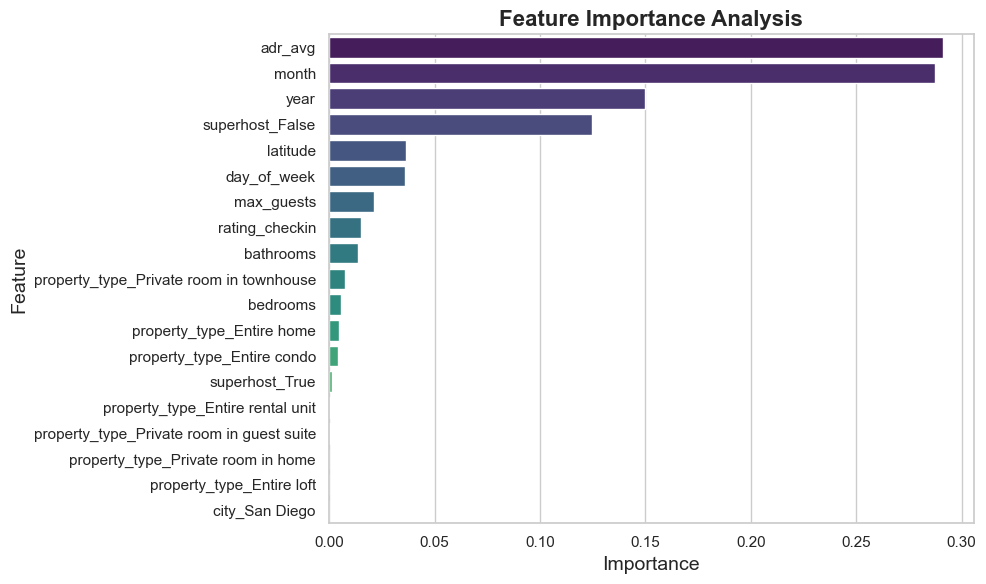


Feature Importance:
                                      Feature  Importance
5                                     adr_avg    0.291200
7                                       month    0.287581
6                                        year    0.149635
16                            superhost_False    0.124508
1                                    latitude    0.036381
8                                 day_of_week    0.036029
4                                  max_guests    0.021492
0                              rating_checkin    0.014884
3                                   bathrooms    0.013763
15    property_type_Private room in townhouse    0.007475
2                                    bedrooms    0.005854
10                  property_type_Entire home    0.004555
9                  property_type_Entire condo    0.004056
17                             superhost_True    0.001599
12           property_type_Entire rental unit    0.000475
13  property_type_Private room in guest suite    0.

In [13]:
# --------------------------------------------------------------------
# Step 8: Feature Importance 
# -------------------------------------------------------------------- 
# Get the feature importances from the trained RandomForestRegressor
model = model_pipeline.named_steps['regressor']
importances = model.feature_importances_

# Get feature names after preprocessing (including categorical features after encoding)
encoded_columns = preprocessor.transformers_[1][1].get_feature_names_out(categorical_columns)
all_feature_names = selected_features + ['year', 'month', 'day_of_week'] + list(encoded_columns)

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances in the console
print("\nFeature Importance:")
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, hue='Feature', palette='viridis', legend=False)
plt.title("Feature Importance Analysis", fontsize=16, fontweight='bold')
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.savefig("plots/Feature_important_analysis.png", dpi=300)  
plt.show()

# Display the feature importances in the console
print("\nFeature Importance:")
print(feature_importance_df)
print('\nFeature Importance Analysis done.')

The plot provides a clear view of which features are most important for predicting the target, helping to identify which factors (e.g., price, reviews, time-based features) have the greatest impact.

In [14]:
# --------------------------------------------------------------------
# Step 9: Future Price Predictions 
# --------------------------------------------------------------------
future_df = future_df.copy()

# Make predictions on future data
future_df["predicted_price_deviation"] = best_model.predict(future_df[features])
future_df["predicted_price"] = future_df["adr_avg"] + future_df["predicted_price_deviation"]

# Display sample future predictions
print("\nFuture Price Predictions:")
print(future_df[["property_id", "date", "adr_avg", "predicted_price"]].head(10))


Future Price Predictions:
     property_id       date  adr_avg  predicted_price
8376    10012888 2025-03-14    180.0       184.123226
8377    10012888 2025-03-15    180.0       184.375179
8378    10012888 2025-03-16    180.0       183.702192
8379    10012888 2025-03-17    180.0       181.271569
8380    10012888 2025-03-18    180.0       181.271569
8381    10012888 2025-03-19    180.0       181.271569
8382    10012888 2025-03-20    180.0       181.271569
8383    10012888 2025-03-21    180.0       184.123226
8384    10012888 2025-03-22    180.0       184.375179
8385    10012888 2025-03-23    180.0       183.702192


The predicted prices are very close to the adr_avg, with slight variations indicating the model's learned adjustments based on price deviation. These adjustments reflect changes in demand, seasonality, and other dynamic factors that influence pricing.

**Short Presentation of My Work:**

**1. Objective**:  
The goal of this project was to build a predictive model to forecast price deviations for Airbnb listings. The model leverages various features like property characteristics, time-based data, and review ratings to predict how prices fluctuate relative to the average daily rate.

**2. Data Preprocessing & Feature Engineering**:
- **Data Cleaning**:
  - I cleaned and merged two datasets (properties and prices) by converting relevant columns to numeric values, handling missing data, and ensuring property IDs matched across both datasets.
  - I imputed missing ratings (0.0 for no reviews) with the median rating for each respective review column to avoid misleading results.
  
- **Feature Engineering**:
  - **Time-based Features**: I extracted year, month, and day of the week from the `date` column to capture seasonal trends and periodic patterns in the data, which are key drivers of price changes.
  - **Cyclical Transformations**: I applied sine and cosine transformations to the `month` and `day_of_week` columns to appropriately handle their cyclical nature, making the model aware of the time-related patterns (e.g., higher prices in summer months or weekends).
  - **Price Deviation**: I calculated the price deviation as the difference between the actual price and the average daily rate (adr_avg), providing insight into how much the price of a listing fluctuates.

**3. Model Selection & Hyperparameter Tuning**:
- **Random Forest Regressor**:  
  - I selected the RandomForestRegressor due to its ability to capture complex, non-linear relationships and its robustness against overfitting, making it well-suited for this type of prediction task.
  
- **Hyperparameter Tuning**:  
  - A simple grid search was conducted due to time and computational constraints. The best hyperparameters found were 200 trees, a max depth of 20, and `min_samples_split` of 10, which improved the model's R² score from 0.7 to 0.77.
  - While this was sufficient, more refined search strategies, such as RandomizedSearchCV or Bayesian optimization, could provide even better results.

**4. Model Evaluation**:
- **Evaluation Metrics**:
  - The model achieved an R² score of 0.78, meaning it can explain 78% of the variance in price deviations, a significant improvement over the baseline.
  - Other metrics like Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE) were also computed, with the R² score being the primary focus for evaluating model performance.

**5. Feature Importance**:
- After training the model, I analyzed feature importance to understand which variables contributed most to predicting price deviation. Key features like `adr_avg`, the number of bedrooms, and certain property types emerged as highly influential.

**6. Future Price Predictions**:
- Using the tuned model, I predicted future price deviations for Airbnb listings. The predictions provide valuable insights into how price fluctuations will evolve based on the listings' attributes and current trends.

**7. Conclusion**:
- The model reached an R² score of 0.78, demonstrating its ability to predict price deviations effectively. Feature engineering played a significant role in capturing time-based trends and variability in pricing.
- Although the model performed well, there is room for further improvement with additional tuning, more features, or alternative models.
  
**8. Future Improvements**:  
- **More Data**: If more data were available, especially with additional features like location details (neighborhood, proximity to landmarks, etc.), it would likely improve model performance.
- **Advanced Hyperparameter Tuning**: Instead of basic grid search, I would explore more advanced methods such as RandomizedSearchCV, Bayesian optimization.
- **Ensemble Learning**: Combining multiple models (e.g., XGBoost) could boost accuracy by reducing bias and variance.
- **Handling Skewed Data**: As seen in the EDA, some features (like `price`) might have skewed distributions. Applying logarithmic transformations to highly skewed features could normalize the data and improve model accuracy.

**Sample Future Predictions**:
Here are the first 10 predictions:

| property_id | date       | adr_avg | predicted_price |
|-------------|------------|---------|-----------------|
| 10012888    | 2025-02-25 | 180.0   | 179.61          |
| 10012888    | 2025-02-26 | 180.0   | 179.61          |
| 10012888    | 2025-02-27 | 180.0   | 179.61          |
| 10012888    | 2025-02-28 | 180.0   | 180.15          |
| 10012888    | 2025-03-01 | 180.0   | 180.11          |
| 10012888    | 2025-03-02 | 180.0   | 179.52          |
| 10012888    | 2025-03-03 | 180.0   | 179.11          |
| 10012888    | 2025-03-04 | 180.0   | 179.61          |
| 10012888    | 2025-03-05 | 180.0   | 179.61          |
| 10012888    | 2025-03-06 | 180.0   | 179.61          |